<a href="https://colab.research.google.com/github/amarsinghen/santander-product-recommendation/blob/master/Santander_Product_Recommendation_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 2.x

In [ ]:
# import tensorflow as tf
# tf.__version__

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
import pandas as pd
import zipfile
from sklearn import preprocessing
import xgboost as xgb 
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import pickle
import gzip
import gc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# !lscpu

Importing the train and test data from google drive

In [ ]:
files = ['train_ver2.csv.zip', 'test_ver2.csv.zip']
for file in files:
  local_zip = '/content/drive/My Drive/datasets/santander-product-recommendation/' + file
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()

In [ ]:
# !cp sample_data '/content/drive/My Drive/datasets/santander-product-recommendation/'

In [ ]:
!head -10 '/tmp/train_ver2.csv'

"fecha_dato","ncodpers","ind_empleado","pais_residencia","sexo","age","fecha_alta","ind_nuevo","antiguedad","indrel","ult_fec_cli_1t","indrel_1mes","tiprel_1mes","indresi","indext","conyuemp","canal_entrada","indfall","tipodom","cod_prov","nomprov","ind_actividad_cliente","renta","segmento","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1","ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1","ind_ecue_fin_ult1","ind_fond_fin_ult1","ind_hip_fin_ult1","ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1","ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"
2015-01-28,1375586,N,ES,H, 35,2015-01-12, 0,      6, 1,,1.0,A,S,N,,KHL,N, 1,29,"MALAGA", 1,87218.1,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0
2015-01-28,1050611,N,ES,V, 23,2012-08-10, 0,     35, 1,,1,I,S,S,,KHE,

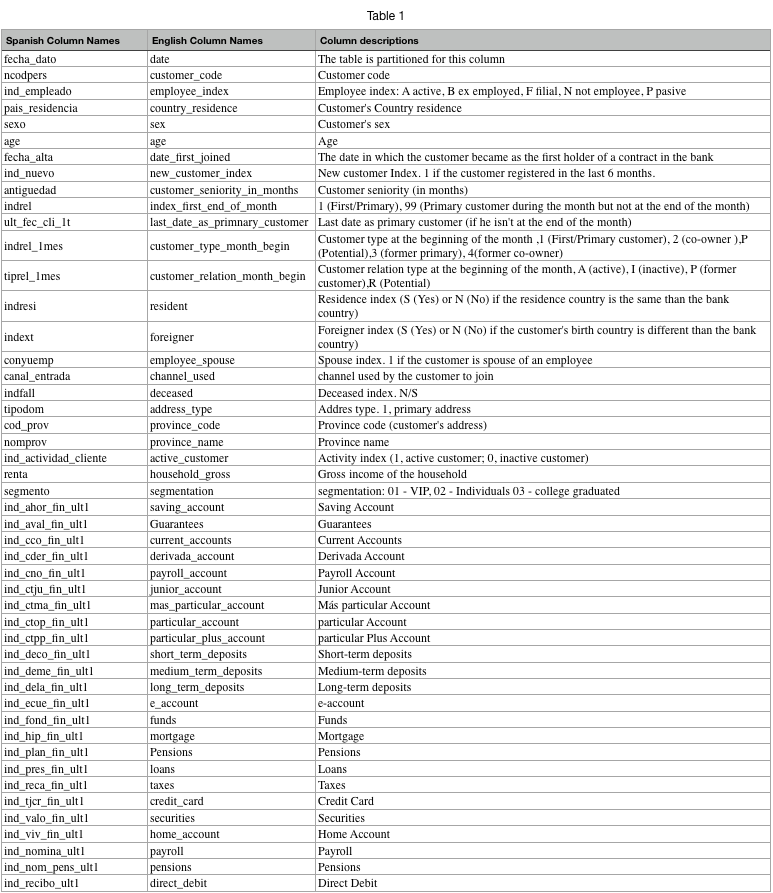

In [ ]:
spr_train_df = pd.read_csv('/tmp/train_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# spr_test_df = pd.read_csv('/tmp/test_ver2.csv')

### Column Names


In [ ]:
spr_train_df.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [ ]:
spr_train_df.columns = ['date','customer_code','employee_index','country_residence','sex','age','date_first_joined','new_customer_index','customer_seniority_in_months','index_first_end_of_month','last_date_as_primary_customer','customer_type_month_begin','customer_relation_month_begin','resident','foreigner','employee_spouse','channel_used','deceased','address_type','province_code','province_name','active_customer','household_gross','segmentation','saving_account','guarantees','current_accounts','derivada_account','payroll_account','junior_account','mas_particular_account','particular_account','particular_plus_account','short_term_deposits','medium_term_deposits','long_term_deposits','e_account','funds','mortgage','pensions_1','loans','taxes','credit_card','securities','home_account','payroll','pensions_2','direct_debit']

In [ ]:
spr_train_df.columns

Index(['date', 'customer_code', 'employee_index', 'country_residence', 'sex',
       'age', 'date_first_joined', 'new_customer_index',
       'customer_seniority_in_months', 'index_first_end_of_month',
       'last_date_as_primary_customer', 'customer_type_month_begin',
       'customer_relation_month_begin', 'resident', 'foreigner',
       'employee_spouse', 'channel_used', 'deceased', 'address_type',
       'province_code', 'province_name', 'active_customer', 'household_gross',
       'segmentation', 'saving_account', 'guarantees', 'current_accounts',
       'derivada_account', 'payroll_account', 'junior_account',
       'mas_particular_account', 'particular_account',
       'particular_plus_account', 'short_term_deposits',
       'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds',
       'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities',
       'home_account', 'payroll', 'pensions_2', 'direct_debit'],
      dtype='object')

In [ ]:
# spr_test_df.columns

In [ ]:
# spr_test_df.columns = ['date','customer_code','employee_index','country_residence','sex','age','date_first_joined','new_customer_index','customer_seniority_in_months','index_first_end_of_month','last_date_as_primary_customer','customer_type_month_begin','customer_relation_month_begin','resident','foreigner','employee_spouse','channel_used','deceased','address_type','province_code','province_name','active_customer','household_gross','segmentation']

In [ ]:
# spr_test_df.columns

### Sample DF Data

In [ ]:
spr_train_df[:5]

,date,customer_code,employee_index,country_residence,sex,age,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# spr_test_df[:5]

In [ ]:
# from pandas_profiling import ProfileReport

### TRAIN DF PROFILE

In [ ]:
# ProfileReport(spr_train_df)

### TEST DF PROFILE

In [ ]:
# ProfileReport(spr_test_df)

### Creating New Dataframes for Data Processing

In [ ]:
spr_train_processed_df = spr_train_df

In [ ]:
del spr_train_df

In [ ]:
spr_train_processed_df.shape

(13647309, 48)

In [ ]:
spr_train_processed_df[:2]

,date,customer_code,employee_index,country_residence,sex,age,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# spr_test_processed_df = spr_test_df

In [ ]:
# spr_test_processed_df[:2]

### Verifying which columns have null values

In [ ]:
spr_train_processed_df.isnull().any()

date                             False
customer_code                    False
employee_index                    True
country_residence                 True
sex                               True
age                              False
date_first_joined                 True
new_customer_index                True
customer_seniority_in_months     False
index_first_end_of_month          True
last_date_as_primary_customer     True
customer_type_month_begin         True
customer_relation_month_begin     True
resident                          True
foreigner                         True
employee_spouse                   True
channel_used                      True
deceased                          True
address_type                      True
province_code                     True
province_name                     True
active_customer                   True
household_gross                   True
segmentation                      True
saving_account                   False
guarantees               

In [ ]:
spr_train_processed_df.isnull().sum()

date                                    0
customer_code                           0
employee_index                      27734
country_residence                   27734
sex                                 27804
age                                     0
date_first_joined                   27734
new_customer_index                  27734
customer_seniority_in_months            0
index_first_end_of_month            27734
last_date_as_primary_customer    13622516
customer_type_month_begin          149781
customer_relation_month_begin      149781
resident                            27734
foreigner                           27734
employee_spouse                  13645501
channel_used                       186126
deceased                            27734
address_type                        27735
province_code                       93591
province_name                       93591
active_customer                     27734
household_gross                   2794375
segmentation                      

### Checking Types of each column

In [ ]:
spr_train_processed_df.dtypes

date                              object
customer_code                      int64
employee_index                    object
country_residence                 object
sex                               object
age                               object
date_first_joined                 object
new_customer_index               float64
customer_seniority_in_months      object
index_first_end_of_month         float64
last_date_as_primary_customer     object
customer_type_month_begin         object
customer_relation_month_begin     object
resident                          object
foreigner                         object
employee_spouse                   object
channel_used                      object
deceased                          object
address_type                     float64
province_code                    float64
province_name                     object
active_customer                  float64
household_gross                  float64
segmentation                      object
saving_account  

## Column by column cleaning up the data

In [ ]:
spr_train_processed_df.describe()

,customer_code,new_customer_index,index_first_end_of_month,address_type,province_code,active_customer,household_gross,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.363125e+07,1.363125e+07,1.364731e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05,1.022912e-04,2.315475e-05,6.554837e-01,3.939238e-04,8.086722e-02,9.474175e-03,9.726606e-03,1.290083e-01,4.330583e-02,1.778739e-03,1.660987e-03,4.296679e-02,8.274357e-02,1.848599e-02,5.886582e-03,9.170965e-03,2.627404e-03,5.253636e-02,4.438868e-02,2.560761e-02,3.847718e-03,5.472434e-02,5.942854e-02,1.279162e-01
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05,1.011340e-02,4.811883e-03,4.752103e-01,1.984361e-02,2.726311e-01,9.687320e-02,9.814275e-02,3.352091e-01,2.035447e-01,4.213757e-02,4.072135e-02,2.027823e-01,2.754942e-01,1.347006e-01,7.649791e-02,9.532502e-02,5.119083e-02,2.231060e-01,2.059571e-01,1.579616e-01,6.191053e-02,2.274414e-01,2.364250e-01,3.339965e-01
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### customer_code

In [ ]:
spr_train_processed_df.customer_code.value_counts()

32752      17
1273696    17
1224536    17
1199940    17
1208128    17
           ..
1549150     1
1543059     1
1535935     1
1551255     1
1489485     1
Name: customer_code, Length: 956645, dtype: int64

In [ ]:
spr_train_processed_df["customer_code"] = pd.to_numeric(spr_train_processed_df["customer_code"], downcast='integer')

### ["employee_index", "index_first_end_of_month","address_type"]
Replacing null values to value with max occurances in each column type

In [ ]:
max_columns = ["employee_index", "index_first_end_of_month", "address_type"]

In [ ]:
for column_name in max_columns:
  # Finding the value with maximum occurance in the column
  value = spr_train_processed_df[column_name].value_counts().idxmax()
  spr_train_processed_df.loc[spr_train_processed_df[column_name].isnull(),column_name] = value

In [ ]:
spr_train_processed_df["index_first_end_of_month"] = pd.to_numeric(spr_train_processed_df["index_first_end_of_month"], downcast='float')
spr_train_processed_df["address_type"] = pd.to_numeric(spr_train_processed_df["address_type"], downcast='float')

### 4. country_residence column - Assigning missing to UK = unknown

In [ ]:
spr_train_processed_df["country_residence"].unique()

array(['ES', nan, 'CA', 'CH', 'CL', 'IE', 'AT', 'NL', 'FR', 'GB', 'DE',
       'DO', 'BE', 'AR', 'VE', 'US', 'MX', 'BR', 'IT', 'EC', 'PE', 'CO',
       'HN', 'FI', 'SE', 'AL', 'PT', 'MZ', 'CN', 'TW', 'PL', 'IN', 'CR',
       'NI', 'HK', 'AD', 'CZ', 'AE', 'MA', 'GR', 'PR', 'RO', 'IL', 'RU',
       'GT', 'GA', 'NO', 'SN', 'MR', 'UA', 'BG', 'PY', 'EE', 'SV', 'ET',
       'CM', 'SA', 'CI', 'QA', 'LU', 'PA', 'BA', 'BO', 'AU', 'BY', 'KE',
       'SG', 'HR', 'MD', 'SK', 'TR', 'AO', 'CU', 'GQ', 'EG', 'ZA', 'DK',
       'UY', 'GE', 'TH', 'DZ', 'LB', 'JP', 'NG', 'PK', 'TN', 'TG', 'KR',
       'GH', 'RS', 'VN', 'PH', 'KW', 'NZ', 'MM', 'KH', 'GI', 'SL', 'GN',
       'GW', 'OM', 'CG', 'LV', 'LT', 'ML', 'MK', 'HU', 'IS', 'LY', 'CF',
       'GM', 'KZ', 'CD', 'BZ', 'ZW', 'DJ', 'JM', 'BM', 'MT'], dtype=object)

In [ ]:
# Verifying if there is an existing value "UK" in the column
spr_train_processed_df.loc[spr_train_processed_df["country_residence"]=='UK',"country_residence"]

Series([], Name: country_residence, dtype: object)

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df["country_residence"].isnull(),"country_residence"] = 'UK'

### 12. customer_type_month_begin column - Assigning missing values to unknown=6, potential(p)=5

In [ ]:
spr_train_processed_df.customer_type_month_begin.unique()

array([1.0, nan, 3.0, 2.0, '1.0', '1', '3', '3.0', '2.0', '4.0', 'P', '4',
       4.0, '2'], dtype=object)

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.customer_type_month_begin == 'P', 'customer_type_month_begin'] = 5

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df['customer_type_month_begin'].isnull(), "customer_type_month_begin"] = 6

In [ ]:
spr_train_processed_df = spr_train_processed_df.astype({'customer_type_month_begin': 'float64'})

In [ ]:
spr_train_processed_df["customer_type_month_begin"] = pd.to_numeric(spr_train_processed_df["customer_type_month_begin"], downcast='float')

In [ ]:
gc.collect()

0

### ["sex","customer_relation_month_begin","resident","foreigner","deceased"] columns
Assinging missing values to "U" = unknown

In [ ]:
u_columns = ["sex","customer_relation_month_begin","resident","foreigner","deceased"]

In [ ]:
for column_name in u_columns:
  spr_train_processed_df.loc[spr_train_processed_df[column_name].isnull(),column_name] = "U"

In [ ]:
gc.collect()

113

### 6. Age column, replacing missing values with average age in the dataset

In [ ]:
spr_train_processed_df.age.unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', ' NA', ' 34', ' 48', ' 46', ' 54', ' 84',
       ' 15', ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52',
       ' 59', ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16',
       ' 11', ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96',
       ' 56', ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64',
       ' 20', ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75',
       '  4', ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91',
       ' 87', ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101',
       '106', '103', '  3', '  2', '102', '104', '111', '107', '109',
       '105', '112', '115', '110', '116', '108', '113', 37, 81, 43, 30,
       45, 41, 67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48,
       60, 54

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.age ==' NA','age'].count() 

27734

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.age==' NA','age'] = 0

In [ ]:
spr_train_processed_df.age.unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', 0, ' 34', ' 48', ' 46', ' 54', ' 84', ' 15',
       ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59',
       ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11',
       ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56',
       ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20',
       ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4',
       ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87',
       ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106',
       '103', '  3', '  2', '102', '104', '111', '107', '109', '105',
       '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41,
       67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54,
       51

In [ ]:
spr_train_processed_df = spr_train_processed_df.astype({'age': 'int64'})

In [ ]:
spr_train_processed_df["age"] = pd.to_numeric(spr_train_processed_df["age"], downcast='integer')

In [ ]:
spr_train_processed_df.age.unique()

array([ 35,  23,  22,  24,  65,  28,  25,  26,  53,  27,  32,  37,  31,
        39,  63,  33,  55,  42,  58,  38,  50,  30,  45,  44,  36,  29,
        60,  57,  67,  47,   0,  34,  48,  46,  54,  84,  15,  12,   8,
         6,  83,  40,  77,  69,  52,  59,  43,  10,   9,  49,  41,  51,
        78,  16,  11,  73,  62,  66,  17,  68,  82,  95,  96,  56,  61,
        79,  72,  14,  19,  13,  86,  64,  20,  89,  71,   7,  70,  74,
        21,  18,  75,   4,  80,  81,   5,  76,  92,  93,  85,  91,  87,
        90,  94,  99,  98,  88,  97, 100, 101, 106, 103,   3,   2, 102,
       104, 111, 107, 109, 105, 112, 115, 110, 116, 108, 113, 126, 117,
       163, 127, 114, 164], dtype=int16)

Populating the interactive namespace from numpy and matplotlib


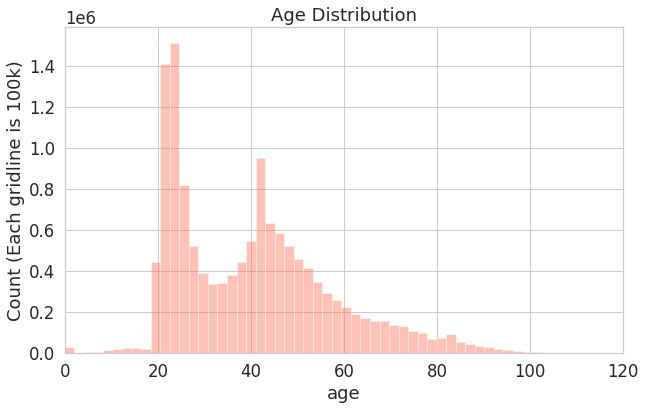

In [ ]:
# Plotting the age distribution "BEFORE" assigning the missing values to mean
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(spr_train_processed_df["age"],
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count (Each gridline is 100k)")
    plt.xlim((0,120))

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.age==0,'age'] = int(spr_train_processed_df.age.mean())

Populating the interactive namespace from numpy and matplotlib


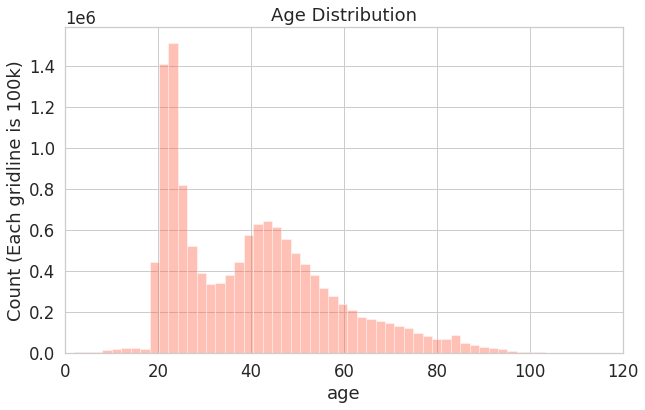

In [ ]:
# Plotting the age distribution "AFTER" assigning the missing values to mean
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(spr_train_processed_df["age"],
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count (Each gridline is 100k)")
    plt.xlim((0,120))

In [ ]:
# Number of records with age < 18
spr_train_processed_df.loc[spr_train_processed_df.age<18, 'age'].count()

118796

In [ ]:
# NUmber of records with age > 100
spr_train_processed_df.loc[spr_train_processed_df.age>120, 'age'].count()

22

In [ ]:
# Creating age groups and adding an age_group feature column to dataframe
spr_train_processed_df['age_group'] = pd.cut(x= spr_train_processed_df['age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 200], 
       labels  = ['1s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s', '110s', '200s'])

In [ ]:
len(spr_train_processed_df[spr_train_processed_df.age_group.isnull()])

0

In [ ]:
# Moving the location of the age_group feature column after the "age". 
# It helps with simplifying the process of creating the correlation heat map of X vs Y columns
columns = spr_train_processed_df.columns.to_list()
columns.remove("age_group")
age_group_location = spr_train_processed_df.columns.get_loc("age") + 1
columns.insert(age_group_location,'age_group')
print(columns)

['date', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'last_date_as_primary_customer', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'employee_spouse', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation', 'saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


In [ ]:
spr_train_processed_df = spr_train_processed_df[columns]

In [ ]:
spr_train_processed_df.head(1)

,date,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1375586,N,ES,H,35,30s,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.1,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# force failure

In [ ]:
gc.collect()

15521

### 7. date_first_joined column - Replacing all missing values with the min() of 'date' column

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df['date_first_joined'].isnull(), 'date_first_joined'] = spr_train_processed_df.date.min()

### 9. customer_seniority_in_months - Replacing NA=0, converting to int type

In [ ]:
# force failure

In [ ]:
spr_train_processed_df.customer_seniority_in_months.unique()

array(['      6', '     35', '     34', '     NA', '     33', '     31',
       '     21', '     16', '     27', '      9', '     22', '     13',
       '     29', '      8', '     11', '     10', '     28', '     24',
       '      7', '     25', '     14', '     26', '     12', '     23',
       '      1', '     18', '      4', '      3', '     17', '     32',
       '     30', '     20', '     15', '     19', '    157', '     36',
       '      5', '     40', '     38', '     37', '     39', '      0',
       '      2', '     47', '     44', '     42', '     46', '     45',
       '     43', '     41', '     57', '     48', '     52', '     49',
       '     50', '     56', '     58', '     51', '     55', '     54',
       '     53', '     59', '     62', '     61', '     60', '     63',
       '    139', '    165', '    118', '    164', '    142', '     94',
       '    159', '    143', '    105', '    151', '    162', '    137',
       '    150', '    128', '    122', '    156', 

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.customer_seniority_in_months.isin(['     NA',-999999, '-999999']), 'customer_seniority_in_months'].count()

27772

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df.customer_seniority_in_months.isin(['     NA',-999999, '-999999']), 'customer_seniority_in_months'] = 0

In [ ]:
spr_train_processed_df = spr_train_processed_df.astype({'customer_seniority_in_months': 'int64'})

In [ ]:
spr_train_processed_df["customer_seniority_in_months"] = pd.to_numeric(spr_train_processed_df["customer_seniority_in_months"], downcast='integer')

In [ ]:
spr_train_processed_df.customer_seniority_in_months.unique()

array([  6,  35,  34,   0,  33,  31,  21,  16,  27,   9,  22,  13,  29,
         8,  11,  10,  28,  24,   7,  25,  14,  26,  12,  23,   1,  18,
         4,   3,  17,  32,  30,  20,  15,  19, 157,  36,   5,  40,  38,
        37,  39,   2,  47,  44,  42,  46,  45,  43,  41,  57,  48,  52,
        49,  50,  56,  58,  51,  55,  54,  53,  59,  62,  61,  60,  63,
       139, 165, 118, 164, 142,  94, 159, 143, 105, 151, 162, 137, 150,
       128, 122, 156, 119, 160,  79,  95, 132, 161,  98, 127,  72, 155,
       108, 163, 102, 148, 115, 146, 107,  81, 216, 135,  92, 121, 198,
       134,  93, 140, 110, 120, 147, 116,  64,  77,  85,  99,  78, 100,
       113, 154, 166, 133, 124, 141,  66, 117,  86, 193,  80, 144,  87,
       126, 158, 101, 235,  88, 145, 103, 149, 109, 131,  97,  68,  84,
       232, 125, 177, 112,  96,  69, 171, 167, 104,  76,  82, 152,  70,
       138, 169,  65, 129, 190, 114, 111, 176, 153,  89, 136,  83, 123,
       187, 106, 231, 189, 217, 172, 199, 173, 174, 209, 180, 17

In [ ]:
gc.collect()

0

### 8. new_customer_index column - Calculating missing values based on the customer_seniority_in_months column

In [ ]:
# Replacing all nulls with 1 based on customer seniority months
spr_train_processed_df.loc[spr_train_processed_df.new_customer_index.isnull() & spr_train_processed_df.customer_seniority_in_months<6,"new_customer_index"]=1

In [ ]:
spr_train_processed_df["new_customer_index"] = pd.to_numeric(spr_train_processed_df["new_customer_index"], downcast='float')

###  channel_used, province_name columns - Replaced null values with "UNK"

In [ ]:
unk_columns = ["channel_used","province_name"]

In [ ]:
for column_name in unk_columns:
  spr_train_processed_df.loc[spr_train_processed_df[column_name].isnull(), column_name] = "UNK"

### 20. province_code column - Replace null with zeros

In [ ]:
spr_train_processed_df.fillna({'province_code':0}, inplace=True)

In [ ]:
spr_train_processed_df["province_code"] = pd.to_numeric(spr_train_processed_df["province_code"], downcast='float')

### 22. active_customer column - Missing values give indication of inactive customers, so assinging them to 0-inactive

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df['active_customer'].isnull(),'active_customer'] = 0

In [ ]:
spr_train_processed_df["active_customer"] = pd.to_numeric(spr_train_processed_df["active_customer"], downcast='float')

In [ ]:
gc.collect()

113

### 23. household_gross column - Replacing with median income per province_name

In [ ]:
# Calculating the median income per province / city 
incomes = spr_train_processed_df.loc[spr_train_processed_df.household_gross.notnull(),:].groupby("province_name").agg({'household_gross':'median'})
incomes.sort_values(by=("household_gross"),inplace=True)
incomes.reset_index(inplace=True)
incomes.head(2)

,province_name,household_gross
0,CIUDAD REAL,62193.45
1,BADAJOZ,62330.97


Text(0.5, 1.0, 'Income Distribution by City')

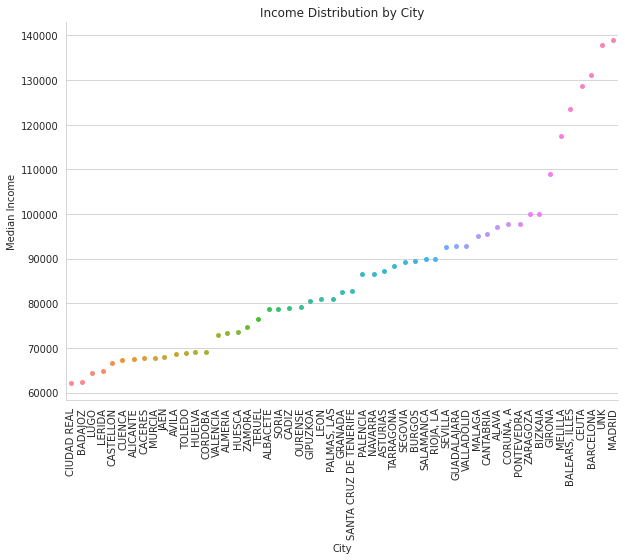

In [ ]:
with sns.axes_style():
    h = sns.catplot(data=incomes,
                   x="province_name",
                   y="household_gross",
                   order=(i for i in incomes.province_name),
                   height=6,
                   aspect=1.5,
                   linestyles="None")
plt.xticks(rotation=90)
plt.ylabel("Median Income")
plt.xlabel("City")
plt.title("Income Distribution by City")

In [ ]:
spr_train_processed_df[spr_train_processed_df.household_gross.isnull()].head(2)

,date,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
4,2015-01-28,1050614,N,ES,V,23,20s,2012-08-10,1.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
8,2015-01-28,1050619,N,ES,H,24,20s,2012-08-10,1.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,20.0,GIPUZKOA,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
len(spr_train_processed_df.loc[spr_train_processed_df['household_gross'].isnull(), 'household_gross'])

2794375

In [ ]:
len(spr_train_processed_df[spr_train_processed_df['household_gross'].isnull()].drop_duplicates(['customer_code']))

247287

In [ ]:
spr_train_processed_df.dtypes

date                               object
customer_code                       int32
employee_index                     object
country_residence                  object
sex                                object
age                                 int16
age_group                        category
date_first_joined                  object
new_customer_index                float32
customer_seniority_in_months        int16
index_first_end_of_month          float32
last_date_as_primary_customer      object
customer_type_month_begin         float32
customer_relation_month_begin      object
resident                           object
foreigner                          object
employee_spouse                    object
channel_used                       object
deceased                           object
address_type                      float32
province_code                     float32
province_name                      object
active_customer                   float32
household_gross                   

In [ ]:
# Dropped the duplicate records of customer to optimize the code processing 
customer_province_df = spr_train_processed_df[spr_train_processed_df['household_gross'].isnull()].drop_duplicates(['customer_code'])[['customer_code','province_name']]
customer_province_df

,customer_code,province_name
4,1050614,ZARAGOZA
8,1050619,GIPUZKOA
11,1050622,GIRONA
14,1050625,ZAMORA
15,1050626,BARCELONA
...,...,...
13632377,1185013,JAEN
13641337,1168909,PONTEVEDRA
13642462,1173729,CORDOBA
13645025,1164094,MURCIA


In [ ]:
# Creating a merged dataframe to map customer_ids to median household gross for people with missing incomes 
merged_df = pd.merge(customer_province_df, incomes, how='left', on='province_name')
merged_df

,customer_code,province_name,household_gross
0,1050614,ZARAGOZA,99950.28
1,1050619,GIPUZKOA,80599.14
2,1050622,GIRONA,108963.21
3,1050625,ZAMORA,74692.71
4,1050626,BARCELONA,131214.48
...,...,...,...
247282,1185013,JAEN,67886.40
247283,1168909,PONTEVEDRA,97829.10
247284,1173729,CORDOBA,69106.89
247285,1164094,MURCIA,67813.86


In [ ]:
merged_df.drop(columns = ['province_name'], inplace=True)
merged_df

,customer_code,household_gross
0,1050614,99950.28
1,1050619,80599.14
2,1050622,108963.21
3,1050625,74692.71
4,1050626,131214.48
...,...,...
247282,1185013,67886.40
247283,1168909,97829.10
247284,1173729,69106.89
247285,1164094,67813.86


In [ ]:
print(type(merged_df.customer_code[0]))
print(type(spr_train_processed_df.customer_code[0]))

<class 'numpy.int32'>
<class 'numpy.int32'>


In [ ]:
# Added the gross median household income to original dataframe for customer with null household_gross, but it created additional columns
spr_train_processed_df = pd.merge(spr_train_processed_df, merged_df, how='left', on='customer_code')
spr_train_processed_df.head(2)

,date,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross_x,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit,household_gross_y
0,2015-01-28,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN
1,2015-01-28,1050611,N,ES,V,23,20s,2012-08-10,1.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN


In [ ]:
# Merging the two columns. It copies NaN with actual float values
spr_train_processed_df['household_gross_x'].update(spr_train_processed_df.pop('household_gross_y'))

In [ ]:
# renaming the column for consistency in dataframe
spr_train_processed_df.rename(columns= {'household_gross_x' : 'household_gross'}, inplace=True)
spr_train_processed_df.head(2)

,date,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,20s,2012-08-10,1.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# checking again to verify there are no more null household_gross values
len(spr_train_processed_df.loc[spr_train_processed_df['household_gross'].isnull(), 'household_gross'])

0

In [ ]:
spr_train_processed_df["household_gross"] = pd.to_numeric(spr_train_processed_df["household_gross"], downcast='float')

In [ ]:
spr_train_processed_df.shape

(13647309, 49)

In [ ]:
del incomes
del merged_df
del customer_province_df

### 24. segmentation column

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df["segmentation"].isnull(),"segmentation"] = "00 - UNKNOWN"

### 46. payroll, and 47. pensions_2 columns - Replacing missing values with values from payroll_account column since there is a very high correlation

In [ ]:
replace_columns = ["payroll", "pensions_2"]

In [ ]:
spr_train_processed_df.loc[spr_train_processed_df['payroll'].isnull(), 'payroll_account']

1922       0
2989       0
4646       0
5666       0
6196       0
          ..
3775976    0
3776175    0
3776230    0
3776279    0
3776332    0
Name: payroll_account, Length: 16063, dtype: int64

In [ ]:
for column_name in replace_columns:
  spr_train_processed_df.loc[spr_train_processed_df[column_name].isnull(),column_name] = spr_train_processed_df.loc[spr_train_processed_df[column_name].isnull(), 'payroll_account']
  spr_train_processed_df[column_name] = pd.to_numeric(spr_train_processed_df[column_name], downcast='integer')

### Adding a "month" Feature column, since there could be trend of certain products in certain months of the year

In [ ]:
spr_train_processed_df['month'] = pd.DatetimeIndex(spr_train_processed_df['date']).month

In [ ]:
spr_train_processed_df[:1]

,date,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit,month
0,2015-01-28,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
spr_train_processed_df['month'] = pd.to_numeric(spr_train_processed_df['month'], downcast='integer')

In [ ]:
# Moving the location of the month feature column after the "date". 
# It helps with simplifying the process of creating the correlation heat map of X vs Y columns
columns = spr_train_processed_df.columns.to_list()
columns.remove("month")
month_location = spr_train_processed_df.columns.get_loc("date") + 1
columns.insert(month_location,'month')
print(columns)

['date', 'month', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'last_date_as_primary_customer', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'employee_spouse', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation', 'saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


In [ ]:
spr_train_processed_df = spr_train_processed_df[columns]

In [ ]:
spr_train_processed_df[:1]

,date,month,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Adding "total_product" feature column. This is to see the number of accounts a customer has each month 

In [ ]:
spr_train_processed_df["total_products"] = spr_train_processed_df.loc[:,"saving_account":"direct_debit"].sum(axis=1)

In [ ]:
spr_train_processed_df["total_products"].dtype

dtype('int64')

In [ ]:
spr_train_processed_df['total_products'] = pd.to_numeric(spr_train_processed_df['total_products'], downcast='integer')

In [ ]:
# Moving the location of the month feature column after the "date". 
# It helps with simplifying the process of creating the correlation heat map of X vs Y columns
columns = spr_train_processed_df.columns.to_list()
columns.remove("total_products")
total_products_location = spr_train_processed_df.columns.get_loc("month") + 1
columns.insert(total_products_location,'total_products')
print(columns)

['date', 'month', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'last_date_as_primary_customer', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'employee_spouse', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation', 'saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


In [ ]:
spr_train_processed_df = spr_train_processed_df[columns]

In [ ]:
spr_train_processed_df.head(2)

,date,month,total_products,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,last_date_as_primary_customer,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,employee_spouse,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1,1,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1,1,1050611,N,ES,V,23,20s,2012-08-10,1.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.738281,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
gc.collect()

40

### Dropping Columns last_date_as_primary_customer and employee_spouse since there are too many missing values

In [ ]:
spr_train_processed_df.drop(columns = ['last_date_as_primary_customer','employee_spouse'], inplace=True)

### Verifying again if any columns have null values

In [ ]:
spr_train_processed_df.isnull().sum()

date                             0
month                            0
total_products                   0
customer_code                    0
employee_index                   0
country_residence                0
sex                              0
age                              0
age_group                        0
date_first_joined                0
new_customer_index               0
customer_seniority_in_months     0
index_first_end_of_month         0
customer_type_month_begin        0
customer_relation_month_begin    0
resident                         0
foreigner                        0
channel_used                     0
deceased                         0
address_type                     0
province_code                    0
province_name                    0
active_customer                  0
household_gross                  0
segmentation                     0
saving_account                   0
guarantees                       0
current_accounts                 0
derivada_account    

In [ ]:
gc.collect()

0

### Downcast all Y columns to save memory

In [ ]:
print(spr_train_processed_df.columns.to_list()[0:25])
print(spr_train_processed_df.columns.to_list()[25:])

['date', 'month', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation']
['saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


## Transforming non-numerical columns to labeled encoders or one-hot depending on the column

In [ ]:
spr_train_encoded_df = spr_train_processed_df
spr_train_encoded_df.dtypes

date                               object
month                                int8
total_products                       int8
customer_code                       int32
employee_index                     object
country_residence                  object
sex                                object
age                                 int16
age_group                        category
date_first_joined                  object
new_customer_index                float32
customer_seniority_in_months        int16
index_first_end_of_month          float32
customer_type_month_begin         float32
customer_relation_month_begin      object
resident                           object
foreigner                          object
channel_used                       object
deceased                           object
address_type                      float32
province_code                     float32
province_name                      object
active_customer                   float32
household_gross                   

In [ ]:
del spr_train_processed_df

In [ ]:
gc.collect()

0

In [ ]:
spr_train_encoded_df.head(2)

,date,month,total_products,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,2015-01-28,1,1,1375586,N,ES,H,35,30s,2015-01-12,1.0,6,1.0,1.0,A,S,N,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1,1,1050611,N,ES,V,23,20s,2012-08-10,1.0,35,1.0,1.0,I,S,S,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.738281,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Since a lot of data is in the String format which we can not feed to classifier, 
# we will encode the column values to labeled integer values
# We only encode the non-integer type of columns
columns_to_encode = spr_train_encoded_df.select_dtypes(include=[object]).columns.tolist()
columns_to_encode.append('age_group')
print(columns_to_encode)

#Labeled Encoder
le = preprocessing.LabelEncoder()
for column_name in columns_to_encode:
    spr_train_encoded_df[column_name] = le.fit_transform(spr_train_encoded_df[column_name])

['date', 'employee_index', 'country_residence', 'sex', 'date_first_joined', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'province_name', 'segmentation', 'age_group']


In [ ]:
spr_train_encoded_df[:1]

,date,month,total_products,customer_code,employee_index,country_residence,sex,age,age_group,date_first_joined,new_customer_index,customer_seniority_in_months,index_first_end_of_month,customer_type_month_begin,customer_relation_month_begin,resident,foreigner,channel_used,deceased,address_type,province_code,province_name,active_customer,household_gross,segmentation,saving_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions_1,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit
0,0,1,1,1375586,3,36,0,35,6,6257,1.0,6,1.0,1.0,0,1,0,153,0,1.0,29.0,31,1.0,87218.101562,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # OneHOT Encoding - one-hot encoding customer_code and age_group columns
# columns_to_onehot = ['age_group']
# one_hot_encoder = preprocessing.OneHotEncoder()
# for column_name in columns_to_onehot:
#     spr_train_encoded_df[column_name] = one_hot_encoder.fit_transform(spr_train_processed_df[column_name])

In [ ]:
# spr_train_encoded_df.info()

In [ ]:
for column_name in spr_train_encoded_df.columns:
  if spr_train_encoded_df[column_name].dtype == "int64":
    spr_train_encoded_df[column_name] = pd.to_numeric(spr_train_encoded_df[column_name], downcast='integer')
  elif spr_train_encoded_df[column_name].dtype == "float64":
    spr_train_encoded_df[column_name] = pd.to_numeric(spr_train_encoded_df[column_name], downcast='float')

In [ ]:
spr_train_encoded_df.dtypes

date                                int8
month                               int8
total_products                      int8
customer_code                      int32
employee_index                      int8
country_residence                   int8
sex                                 int8
age                                int16
age_group                           int8
date_first_joined                  int16
new_customer_index               float32
customer_seniority_in_months       int16
index_first_end_of_month         float32
customer_type_month_begin        float32
customer_relation_month_begin       int8
resident                            int8
foreigner                           int8
channel_used                       int16
deceased                            int8
address_type                     float32
province_code                    float32
province_name                       int8
active_customer                  float32
household_gross                  float32
segmentation    

### Saving the encoded version of the file as a pickle_file
We can use this dataframe in a separate jupyter notebook specific for modeling. This helps in managing the memory per single colab jupyter notebook

In [ ]:
with gzip.open("/content/drive/My Drive/santander-product-recommendation/train_encoded_version.pkl.gz", "wb") as pickle_file:
  pickle.dump(spr_train_encoded_df, pickle_file)

In [ ]:
forced _failure

SyntaxError: ignored

### Saving the encoded version of dataframe in a csv file.
We can use this dataframe in a separate jupyter notebook specific for modeling.
This helps in managing the memory per single colab jupyter notebook

In [ ]:
spr_train_encoded_df.to_csv('/content/drive/My Drive/santander-product-recommendation/train_encoded_version.csv',index=False, encoding='utf-8')

### Now lets look at the correlation matrix

Opening the saved pickeled model first. 
Had to reset the runtime on Google Colab after data preprocessing becasue almost all RAM was used.

In [ ]:
with gzip.open("/content/drive/My Drive/santander-product-recommendation/train_encoded_version.pkl.gz", "rb") as pickle_file:
  spr_train_encoded_df = pd.read_pickle(pickle_file)

In [ ]:
X_columns = spr_train_encoded_df.columns.to_list()[0:25]
print(X_columns)
Y_columns = spr_train_encoded_df.columns.to_list()[25:]
print(Y_columns)

['date', 'month', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation']
['saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


In [ ]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (20, 10),
         'xtick.labelsize':10,
         'ytick.labelsize':10}
pylab.rcParams.update(params)

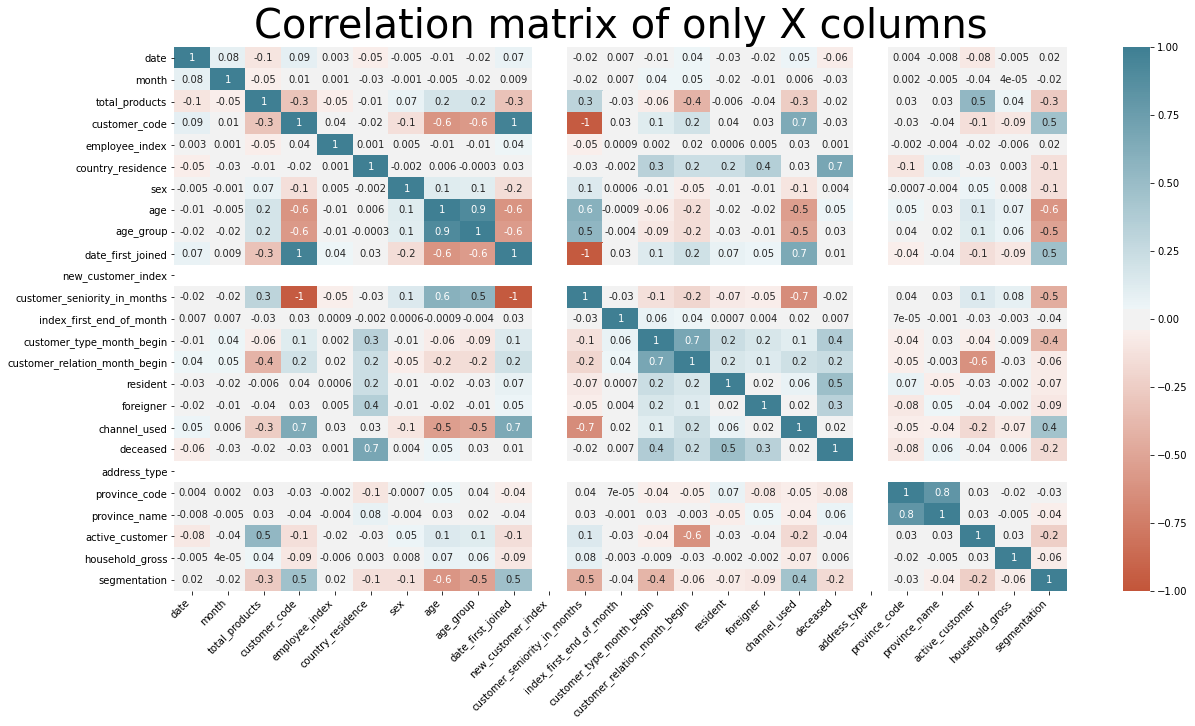

In [ ]:
# Heatmap for correlation matrix of only X columns. 
corr_matrix_X = spr_train_encoded_df[X_columns].corr()
# sns.heatmap(corrMatrix, annot=True, )
ax = sns.heatmap(
    corr_matrix_X, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=256),
    fmt='.1g',
    annot=True,
    # mask=np.triu(corr_matrix_X),
    annot_kws={"size": 10}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Correlation matrix of only X columns", fontsize = 40)
plt.show()

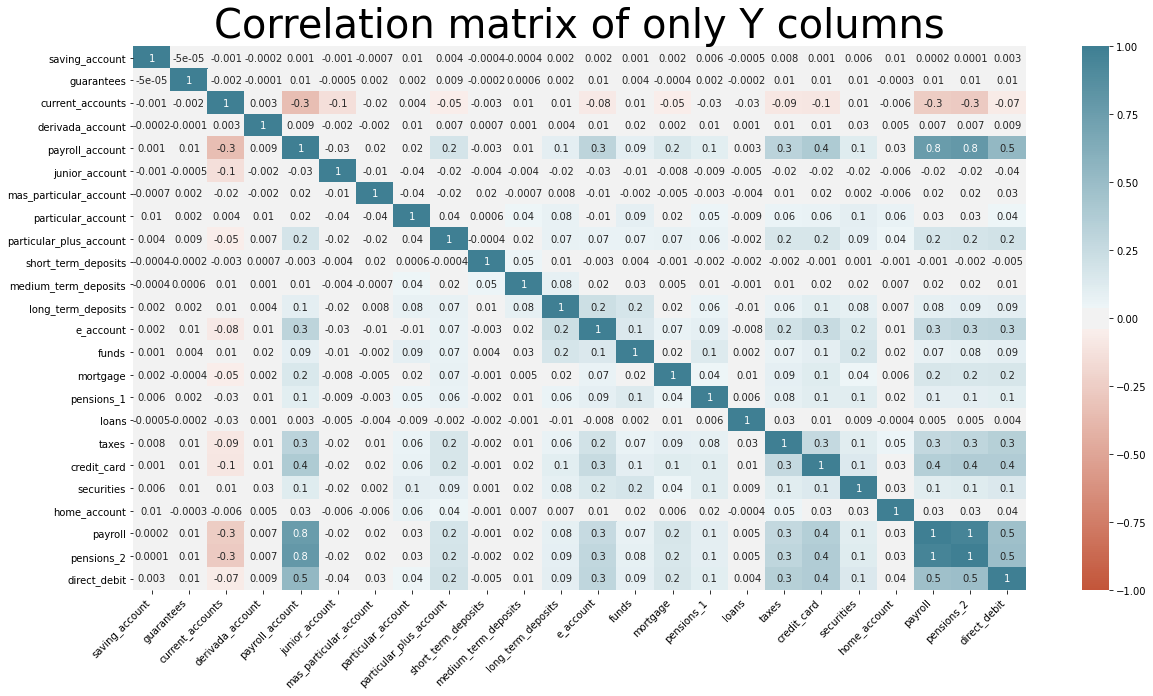

In [ ]:
# Heatmap for correlation matrix of only Y columns
corr_matrix_Y = spr_train_encoded_df[Y_columns].corr()
# sns.heatmap(corrMatrix, annot=True, )
ax = sns.heatmap(
    corr_matrix_Y, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=256),
    fmt='.1g',
    # mask=np.triu(corr_matrix_Y),
    annot=True,
    annot_kws={"size": 10}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Correlation matrix of only Y columns", fontsize = 40)
plt.show()

In [ ]:
#Calculating the correlation matrix of all columns
corr_matrix_X_Y_temp = spr_train_encoded_df.corr()
print(corr_matrix_X_Y_temp.shape)
print(type(corr_matrix_X_Y_temp))

(49, 49)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# converting to numpy arrays. It makes it very easy to have selective columns in the matrix later
np1 = np.array(corr_matrix_X_Y_temp)
print(type(np1))
print(np1.shape)

<class 'numpy.ndarray'>
(49, 49)


In [ ]:
# Only selecting the X and Y columns to simplify the heatmap
corr_matrix_X_Y = np1[:25,25:]
corr_matrix_X_Y.shape

(25, 24)

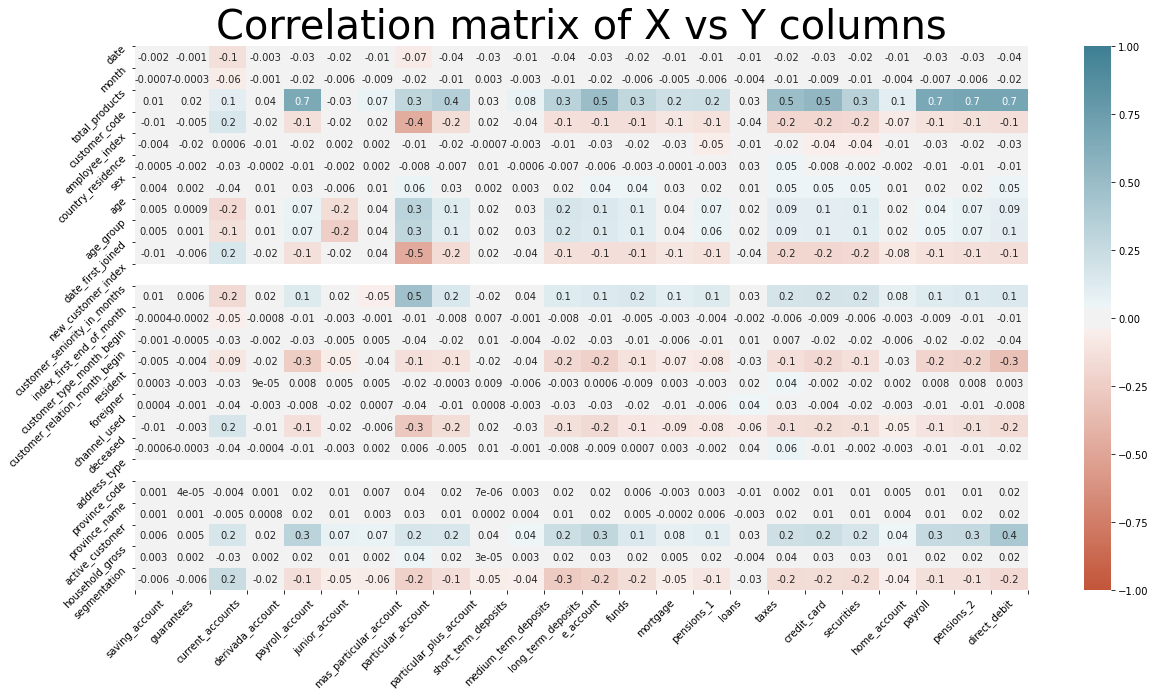

In [ ]:
ax = sns.heatmap(
    corr_matrix_X_Y,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=256),
    fmt='.1g',
    annot=True,
    annot_kws={"size": 10}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    va='center_baseline'
)
plt.xticks(ticks=np.arange(0,25),labels=Y_columns)
plt.yticks(ticks=np.arange(0,25), labels=X_columns)
plt.title("Correlation matrix of X vs Y columns", fontsize = 40)
plt.show()

In [ ]:
del corr_matrix_X
del corr_matrix_Y
del corr_matrix_X_Y_temp
del corr_matrix_X_Y
del np1


In [ ]:
gc.collect()

### Now we will look at the feature importances from xgboost and randomforest models

In [ ]:
with gzip.open("santander_rfc_model_06272020_Full_1.pkl.gz", "rb") as pickle_file:
  xgb_model = pd.read_pickle(pickle_file)

In [ ]:
feat_importances = [] 
for clf in xgb_model.estimators_:
    feat_importances.append(clf.feature_importances_)
print(feat_importances[:2])

[array([1.27489197e-02, 6.03917260e-03, 4.63663601e-02, 2.71800064e-01,
       2.58090197e-03, 6.11602951e-05, 1.49705877e-02, 5.30787477e-02,
       1.13253588e-02, 1.95179353e-01, 0.00000000e+00, 4.76875937e-02,
       6.12726407e-05, 1.65906653e-05, 1.11444109e-02, 4.22757035e-04,
       4.14240328e-03, 2.81220411e-02, 4.08954054e-05, 0.00000000e+00,
       2.59513703e-02, 2.82552961e-02, 1.04574667e-02, 2.22660633e-01,
       6.88664299e-03]), array([2.26186184e-02, 1.15256267e-02, 5.62154950e-02, 2.68387363e-01,
       9.82663477e-03, 8.12263299e-03, 1.43395234e-02, 5.84688116e-02,
       7.69440014e-03, 1.96642248e-01, 0.00000000e+00, 6.05031077e-02,
       5.53375736e-08, 7.56303599e-06, 2.32920785e-04, 6.06715831e-04,
       5.71300690e-04, 2.40246672e-02, 4.10397827e-08, 0.00000000e+00,
       7.39475599e-03, 3.68983827e-03, 1.13359003e-03, 2.31297823e-01,
       1.66962667e-02])]


In [ ]:
print(len(feat_importances))
print(feat_importances[1])

24
[2.26186184e-02 1.15256267e-02 5.62154950e-02 2.68387363e-01
 9.82663477e-03 8.12263299e-03 1.43395234e-02 5.84688116e-02
 7.69440014e-03 1.96642248e-01 0.00000000e+00 6.05031077e-02
 5.53375736e-08 7.56303599e-06 2.32920785e-04 6.06715831e-04
 5.71300690e-04 2.40246672e-02 4.10397827e-08 0.00000000e+00
 7.39475599e-03 3.68983827e-03 1.13359003e-03 2.31297823e-01
 1.66962667e-02]


In [ ]:
X_columns = ['date', 'month', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation']

Y_columns = ['saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']

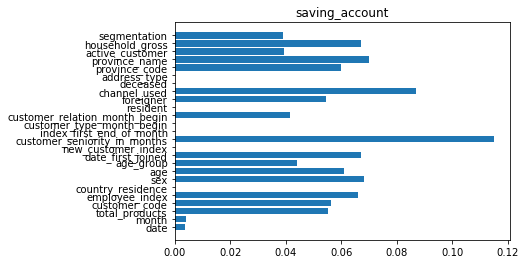

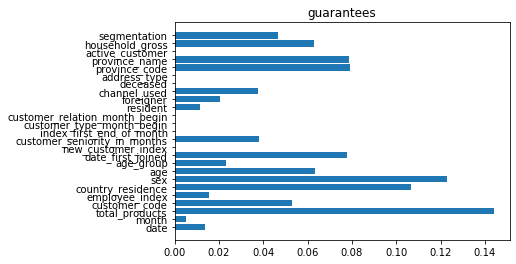

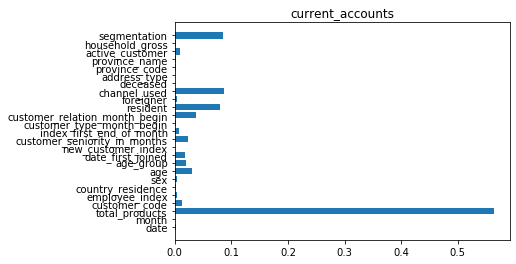

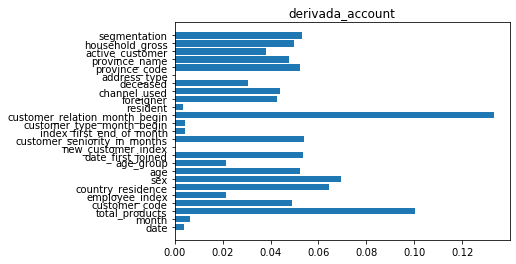

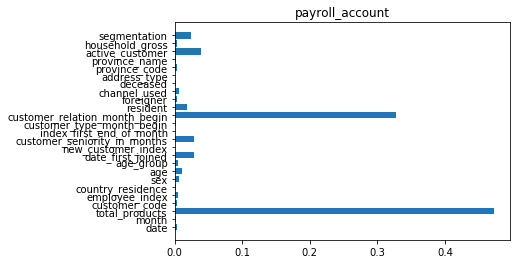

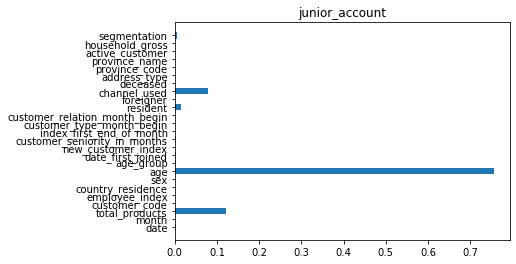

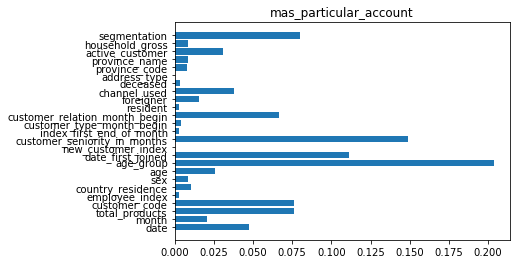

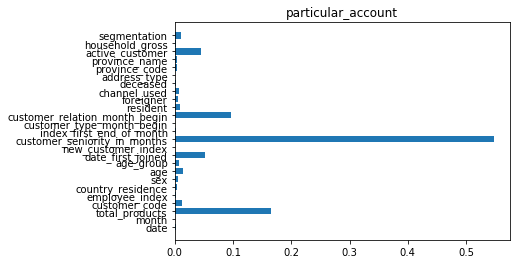

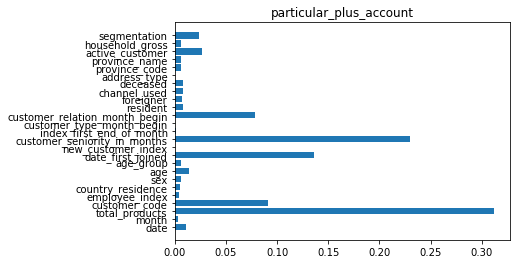

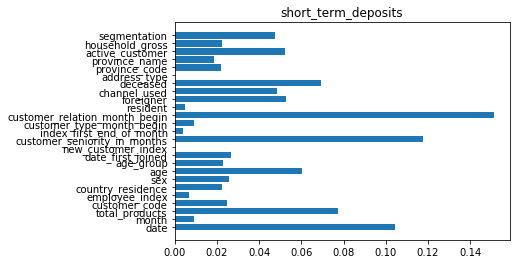

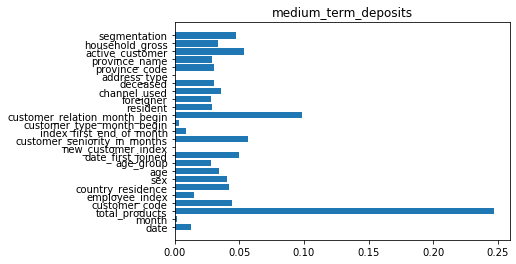

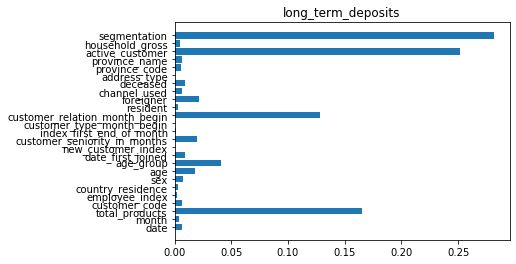

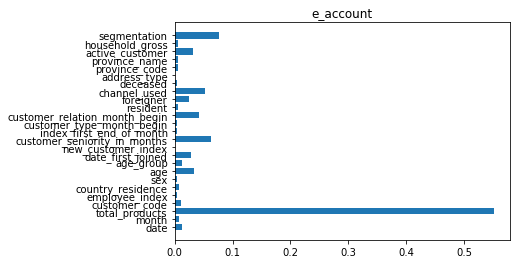

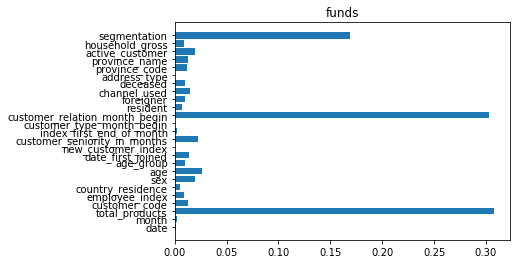

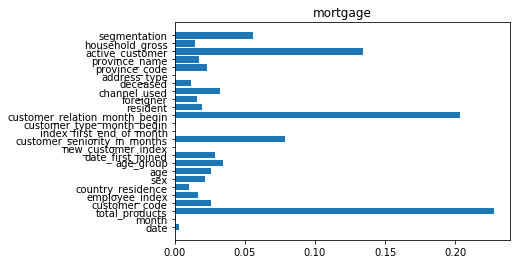

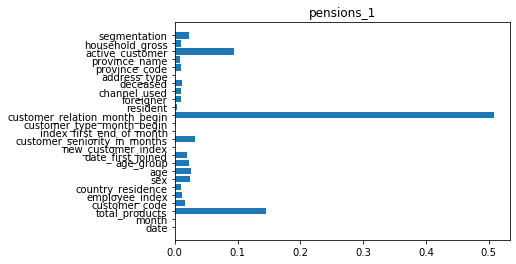

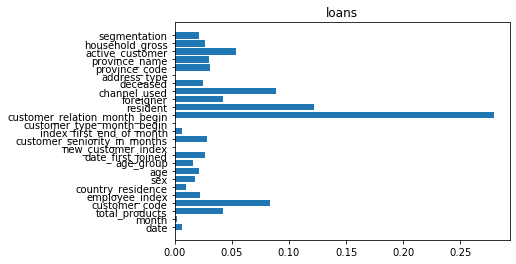

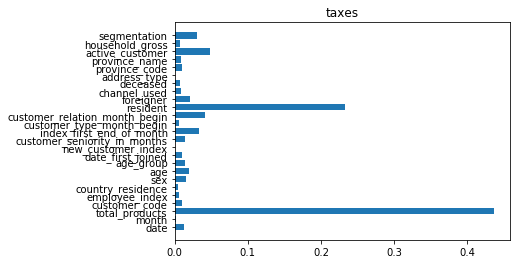

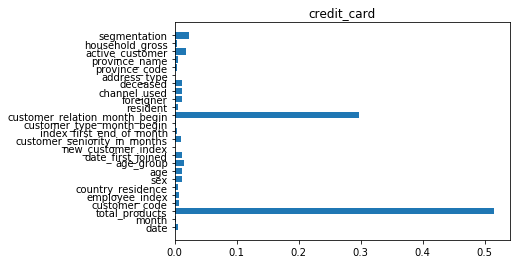

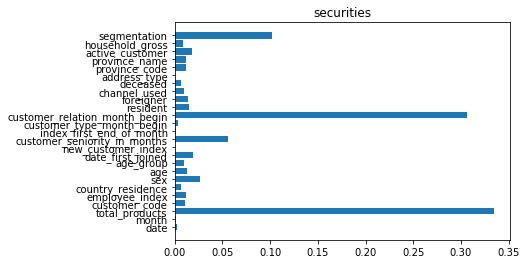

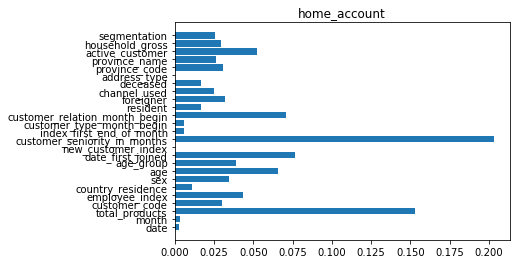

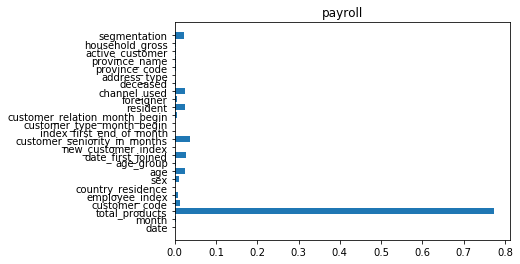

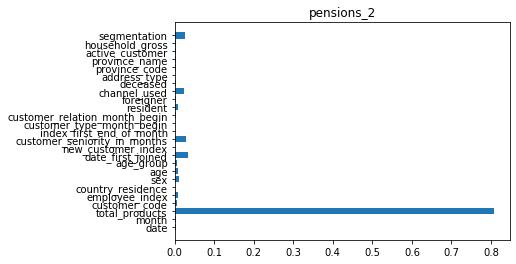

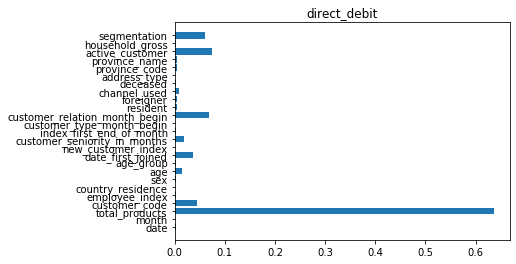

In [ ]:
# XGboost Full - santander_xgb_model_06272020_830PM_Full.pkl.gz
# for i in range(len(feat_importances)):
#     plt.title(Y_columns[i])
#     plt.barh(range(len(feat_importances[i])), feat_importances[i])
#     plt.yticks(ticks=np.arange(0,25), labels=X_columns)
#     plt.show()
#     plt.close()

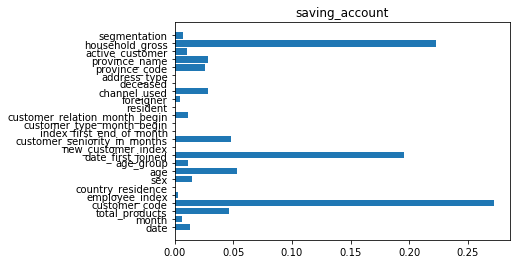

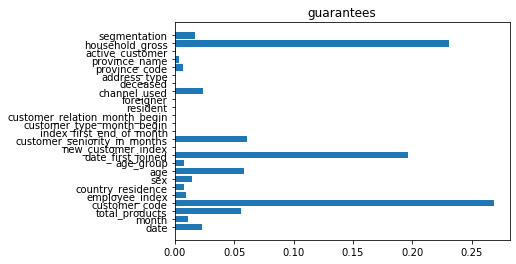

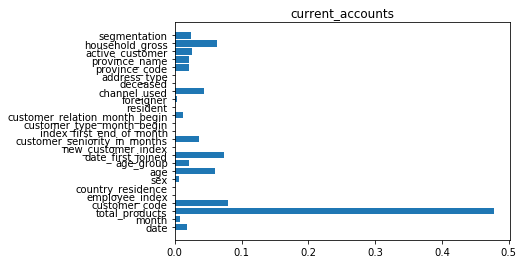

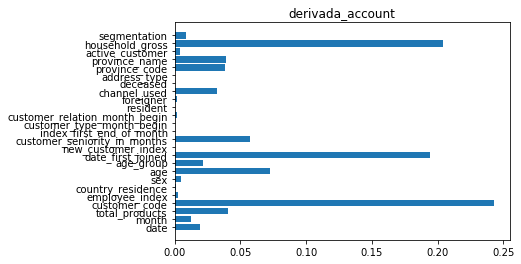

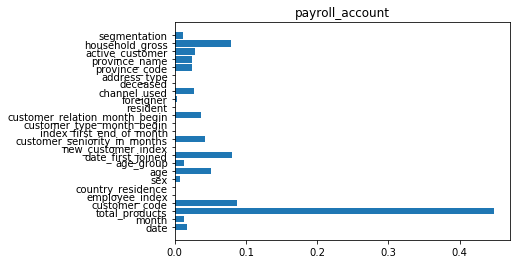

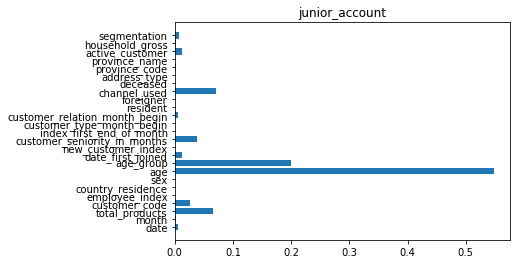

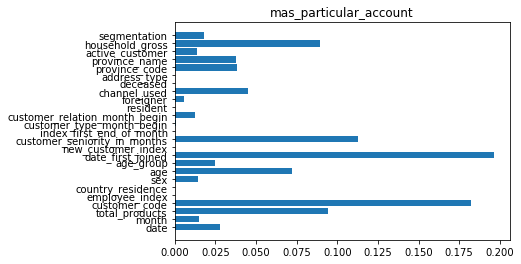

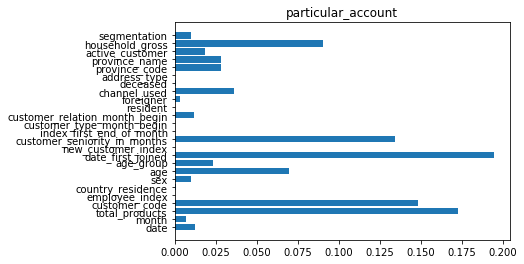

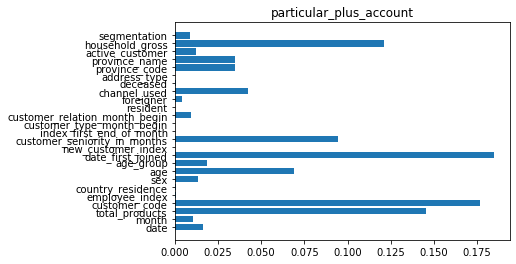

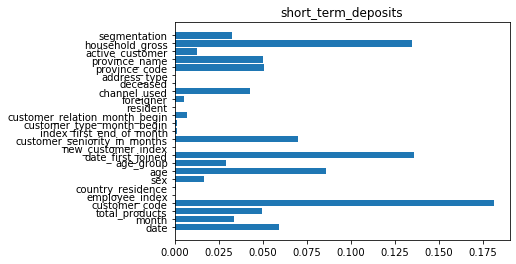

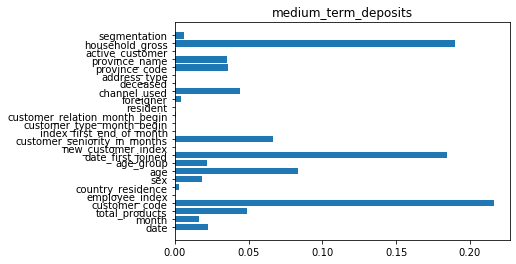

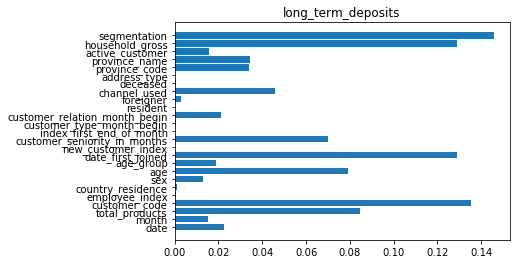

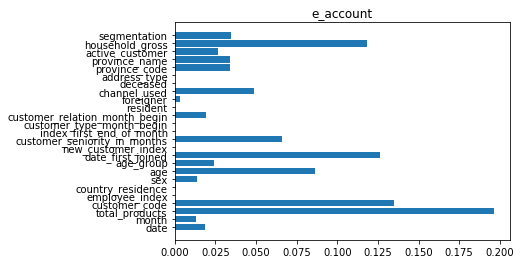

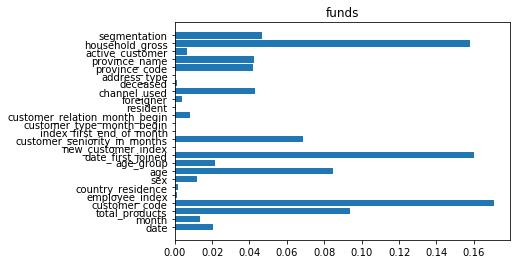

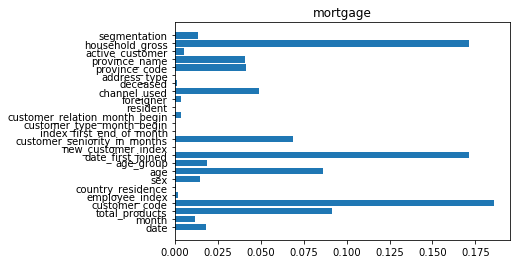

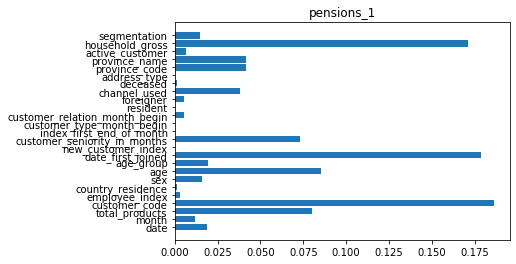

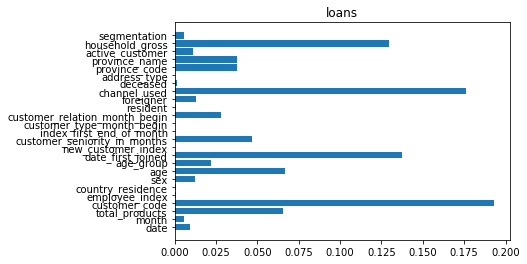

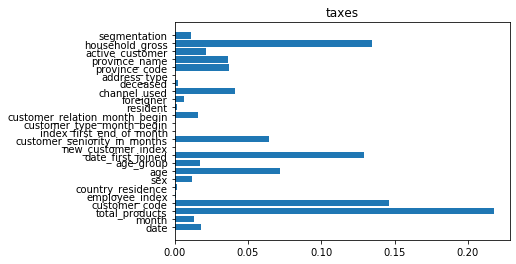

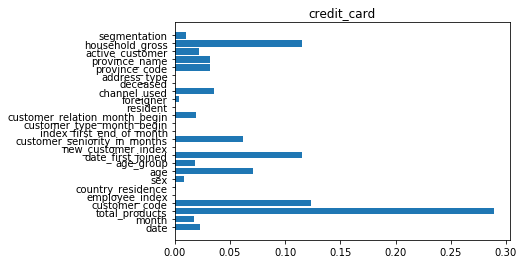

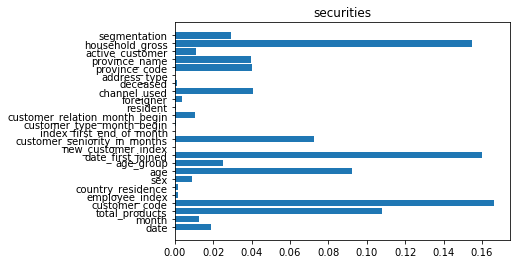

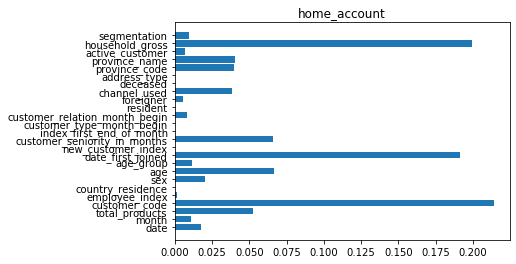

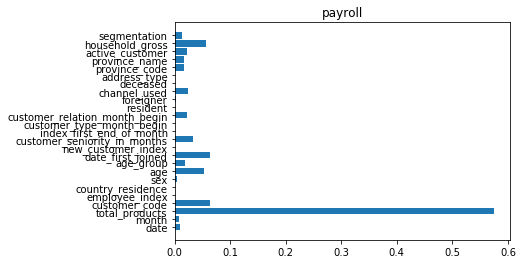

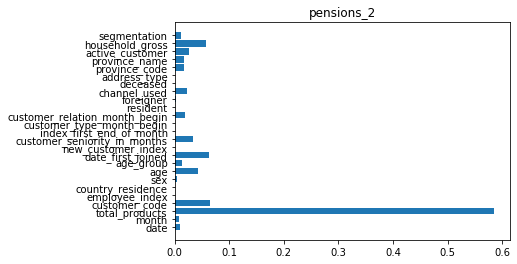

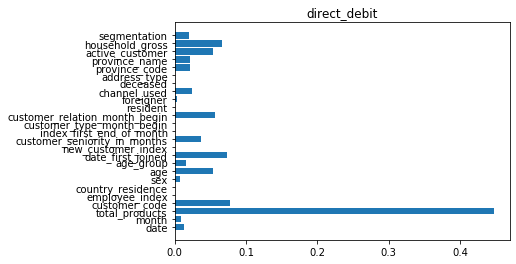

In [ ]:
#Random Forest full - santander_rfc_model_06272020_Full_1.pkl.gz
# for i in range(len(feat_importances)):
#     plt.title(Y_columns[i])
#     plt.barh(range(len(feat_importances[i])), feat_importances[i])
#     plt.yticks(ticks=np.arange(0,25), labels=X_columns)
#     plt.show()
#     plt.close()

Fetaure Importance of XGB GridSearch for individual Y_targets

In [3]:
for i in range(24):
  with gzip.open('/content/drive/My Drive/santander-product-recommendation/xgb_grid_search_models1/santander_xgb_grid_search_model_07022020_yTarget{}.pkl.gz'.format(i+1), 'rb') as pickle_file:
    xgb_grid_search_model = pd.read_pickle(pickle_file)
  print('y_target : {}'.format(i+1))
  print(xgb_grid_search_model.best_params_)
  print(xgb_grid_search_model.best_score_)
  print(xgb_grid_search_model.best_estimator_)
  print(xgb_grid_search_model.cv_results_)
  print()

y_target : 1
{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 300}
0.9960145196596348
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
{'mean_fit_time': array([ 4.39031005, 10.2173245 ,  7.09317267,  3.79922414,  8.36519206,
        6.00634623,  3.96987975,  9.55667377,  6.57365561,  4.67447054,
        9.90735734,  7.43543398,  4.09242737,  8.87035894,  6.47633386,
        4.47130346,  9.71935987,  7.2002331 ,  4.53968596, 10.22703815,
        7.4957881 ,  4.0079186 ,  8.87374413,  6.40512788,  4.33451498,
        9.8060658 ,  7.0851

In [4]:
xgb_grid_search_model.estimator.feature_importances_

XGBoostError: ignored

In [ ]:
feat_importances = [] 
for clf in xgb_model.estimators_:
    feat_importances.append(clf.feature_importances_)
print(feat_importances[:2])